# Simple Example

## Introduction

In this example, we present an existing method [1] and our new method on a very simple simulated dataset. <br>
We compare both methods based on simplicity, goodness of fit and performance. <br>
<br>
[1] On the Analysis of Discrete Time Competing Risks Data, Biometrics, Lee et al. 2018

## Data Generation

We simulate N=10000 patients, with 5 covariate $Z_p$ ($p \in \mathbb{Z} [1, 5]$) randomly sampled from $\mathbb{R} [0,1]$. <br> <br>
Our timeline is discrete, i.e $t \in \mathbb{Z} [1, d]$, and here we choose $d=120$. <br> <br>
For each of the samples, we calculate it's event time $T_i$ such that $T = Z_{1}d$, and randomly sample a censoring time $C_i$ such that $C_i \sim Uniform[1, d]$. <br>
The event type $J_i$ is randomly sampled from $J_i \sim Uniform[1, M]$, where $M$ is the number of competing events. In this example $M=2$. <br><br>
We then calculate $X_i = min(T_i, C_i)$ and for cencored samples we set the event type to be $J=0$. <br><br>
Lastly, we split the data into two separate datasets for training (75%) and for testing (25%).

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pydts.utils import get_expanded_df
from tqdm import tqdm
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lifelines.fitters.coxph_fitter import CoxPHFitter
from scipy.special import expit
from scipy.optimize import minimize
import sys
sys.path.append('../')
sys.path.append('../../')
from examples.generate_simulations_data import generate_quick_start_df
import warnings
warnings.filterwarnings('ignore')

In [2]:
n_cov = 5
patients_df = generate_quick_start_df(n_patients=10000, n_cov=n_cov, d_times=120, j_events=2, pid_col='pid', 
                                      seed=0)
covariates = [f'Z{i + 1}' for i in range(n_cov)]

train_df, test_df = train_test_split(patients_df, test_size=0.25)
events = sorted(train_df['J'].unique())
times = sorted(train_df['X'].unique())
train_df.head()  

,pid,Z1,Z2,Z3,Z4,Z5,T,C,X,J
440,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,12.0,1
2709,2709,0.175463,0.889782,0.297725,0.758235,0.517933,21.0,29,21.0,1
93,93,0.171853,0.449292,0.304468,0.839189,0.237742,21.0,24,21.0,2
3429,3429,0.734049,0.563797,0.972714,0.071323,0.010224,88.0,63,63.0,0
3583,3583,0.345704,0.421931,0.574230,0.716075,0.066058,41.0,29,29.0,0


## Lee et al. 2018 [1]

Lee et al. suggested to expand the data so that for each patient we have row for each $t \in [1, T_i]$, with binary event columns which are 1 only at the time of the event. here $j_0 = 1 - j_1 - j_2$. <br> <br>
Then, for each event we estimate {$\alpha_{jt}, \beta_{j}$} using a binary regression model.

In [3]:
expanded_train_df = get_expanded_df(train_df)
print(expanded_train_df.shape)
expanded_train_df

(301491, 13)


,pid,Z1,Z2,Z3,Z4,Z5,T,C,X,J,j_0,j_1,j_2
0,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,1,1,1.0,0.0,0.0
1,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,2,1,1.0,0.0,0.0
2,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,3,1,1.0,0.0,0.0
3,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,4,1,1.0,0.0,0.0
4,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,5,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301486,7000,0.790919,0.282501,0.027796,0.145497,0.649263,95.0,39,35,0,1.0,0.0,0.0
301487,7000,0.790919,0.282501,0.027796,0.145497,0.649263,95.0,39,36,0,1.0,0.0,0.0
301488,7000,0.790919,0.282501,0.027796,0.145497,0.649263,95.0,39,37,0,1.0,0.0,0.0
301489,7000,0.790919,0.282501,0.027796,0.145497,0.649263,95.0,39,38,0,1.0,0.0,0.0


In [4]:
expanded_train_df = pd.concat([expanded_train_df, 
                               pd.get_dummies(expanded_train_df['X'], prefix='alpha')], axis=1)
expanded_train_df

,pid,Z1,Z2,Z3,Z4,Z5,T,C,X,J,...,alpha_110,alpha_111,alpha_112,alpha_113,alpha_114,alpha_115,alpha_116,alpha_117,alpha_118,alpha_119
0,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,1,1,...,0,0,0,0,0,0,0,0,0,0
1,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,2,1,...,0,0,0,0,0,0,0,0,0,0
2,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,3,1,...,0,0,0,0,0,0,0,0,0,0
3,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,4,1,...,0,0,0,0,0,0,0,0,0,0
4,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,5,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301486,7000,0.790919,0.282501,0.027796,0.145497,0.649263,95.0,39,35,0,...,0,0,0,0,0,0,0,0,0,0
301487,7000,0.790919,0.282501,0.027796,0.145497,0.649263,95.0,39,36,0,...,0,0,0,0,0,0,0,0,0,0
301488,7000,0.790919,0.282501,0.027796,0.145497,0.649263,95.0,39,37,0,...,0,0,0,0,0,0,0,0,0,0
301489,7000,0.790919,0.282501,0.027796,0.145497,0.649263,95.0,39,38,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
alpha_list = [col for col in expanded_train_df.columns if col[:5] == 'alpha']
models = {}

In [6]:
start = time()

for e in tqdm(events[1:], total=len(events)-1):
    model = LogisticRegression()
    X, y =  expanded_train_df[covariates + alpha_list].values, expanded_train_df[f'j_{e}'].values
    model.fit(X, y)
    models[e] = model

end = time()

100%|█████████████████████████████████████████████| 2/2 [00:20<00:00, 10.36s/it]


In [7]:
print(f'Total training time: {end - start:.2f} seconds')

Total training time: 20.73 seconds


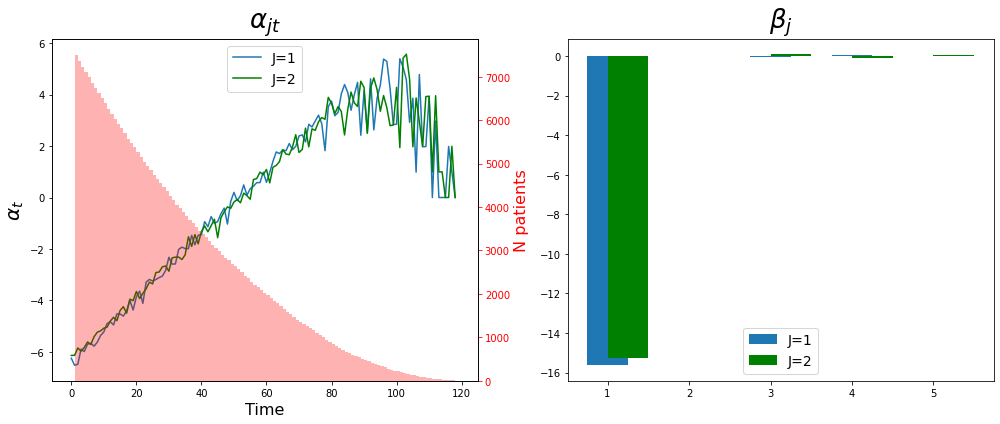

In [8]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
ax = axes[0]
ax.set_title(r'$\alpha_{jt}$', fontsize=26)
ax.plot(models[1].coef_[0, n_cov:], label='J=1')
ax.plot(models[2].coef_[0, n_cov:], color='g', label='J=2')
ax.set_xlabel(r'Time', fontsize=16)
ax.set_ylabel(r'$\alpha_{t}$', fontsize=20)
ax.legend(loc='upper center', fontsize=14)
ax2 = ax.twinx()
ax2.hist(expanded_train_df['X'], color='r', alpha=0.3, bins=times)
ax2.set_ylabel('N patients', fontsize=16, color='red')
ax2.tick_params(axis='y', colors='red')

ax = axes[1]
ax.set_title(r'$\beta_{j}$', fontsize=26)
ax.bar(np.arange(1, n_cov+1), models[1].coef_[0, :n_cov], label='J=1', width=0.5)
ax.bar(np.arange(1, n_cov+1), models[2].coef_[0, :n_cov], color='g', label='J=2', align='edge', width=0.5)
ax.legend(loc='lower center', fontsize=14)

fig.tight_layout()

In [9]:
# test mse

## New approach

Here, for each event, we first estimate $\beta_{j}$ using a time-stratified CoxPH model and the expanded data as we used in the previous approach. <br> <br>
Afterwards, we evaluate $\alpha_{jt}$ based on the original training data.

In [10]:
beta_models = {}

for e in events[1:]:
    strata_df = expanded_train_df[covariates + [f'j_{e}', 'X']].copy()
    strata_df['X_copy'] = expanded_train_df['X']

    beta_j_cox = CoxPHFitter()
    beta_j_cox.fit(df=strata_df[covariates+ ['X', 'X_copy', f'j_{e}']], duration_col='X', event_col=f'j_{e}', 
                   strata='X_copy')
    beta_models[e] = beta_j_cox
    #print(beta_j_cox.params_)

Going back to the unexpanded data: 

In [11]:
train_df.head()

,pid,Z1,Z2,Z3,Z4,Z5,T,C,X,J
440,440,0.102072,0.756935,0.339651,0.637969,0.603783,12.0,106,12.0,1
2709,2709,0.175463,0.889782,0.297725,0.758235,0.517933,21.0,29,21.0,1
93,93,0.171853,0.449292,0.304468,0.839189,0.237742,21.0,24,21.0,2
3429,3429,0.734049,0.563797,0.972714,0.071323,0.010224,88.0,63,63.0,0
3583,3583,0.345704,0.421931,0.574230,0.716075,0.066058,41.0,29,29.0,0


In [12]:
y_t = len(train_df['X']) - train_df['X'].value_counts().sort_index().cumsum()
y_t.head()

1.0    7357
2.0    7229
3.0    7107
4.0    6990
5.0    6866
Name: X, dtype: int64

In [13]:
n_jt = train_df.groupby(['J', 'X']).size().to_frame().reset_index()
n_jt.columns = ['J', 'X' ,'n_jt']
n_jt.head()

,J,X,n_jt
0,0,1.0,53
1,0,2.0,65
2,0,3.0,55
3,0,4.0,44
4,0,5.0,61


In [14]:
def alpha_jt(x, df, y_t, beta_j, n_jt, t, duration_col='X' ):
    partial_df = df[df[duration_col] >= t]
    expit_add = (partial_df[covariates]*beta_j).sum(axis=1)
    return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2

In [15]:
x0 = 0
alpha_df = pd.DataFrame()
for e in events[1:]:
    n_et = n_jt[n_jt['J'] == e]
    n_et['opt_res'] = n_et.apply(lambda row: minimize(alpha_jt, x0, 
        args=(train_df, y_t.loc[row['X']], beta_models[e].params_,  row['n_jt'],  row['X'])), axis=1)
    n_et['success'] = n_et['opt_res'].apply(lambda val: val.success)
    n_et['alpha_jt'] = n_et['opt_res'].apply(lambda val: val.x[0])
    alpha_df = alpha_df.append(n_et, ignore_index=True)
alpha_df.head(10)

,J,X,n_jt,opt_res,success,alpha_jt
0,1,1.0,46,"{'fun': 6.11013893303795e-07, 'jac': [9.775485...",True,-1.258169
1,1,2.0,27,"{'fun': 2.733744020134841e-07, 'jac': [4.15028...",True,-1.395821
2,1,3.0,24,"{'fun': 8.118469262491527e-07, 'jac': [7.18586...",True,-1.111102
3,1,4.0,41,"{'fun': 2.5108457917139604e-07, 'jac': [5.7431...",True,-0.383467
4,1,5.0,31,"{'fun': 3.7032000788895157e-07, 'jac': [5.7265...",True,-0.288246
5,1,6.0,37,"{'fun': 1.5697737258026407e-07, 'jac': [-3.709...",True,0.000000
6,1,7.0,32,"{'fun': 1.2991877413331271e-06, 'jac': [-7.920...",True,0.000000
7,1,8.0,24,"{'fun': 7.764082581126162e-07, 'jac': [-4.7209...",True,0.000000
8,1,9.0,25,"{'fun': 3.108485433995534e-06, 'jac': [-7.3260...",True,0.000000
9,1,10.0,29,"{'fun': 9.016994215474496e-06, 'jac': [-9.5202...",True,0.000000


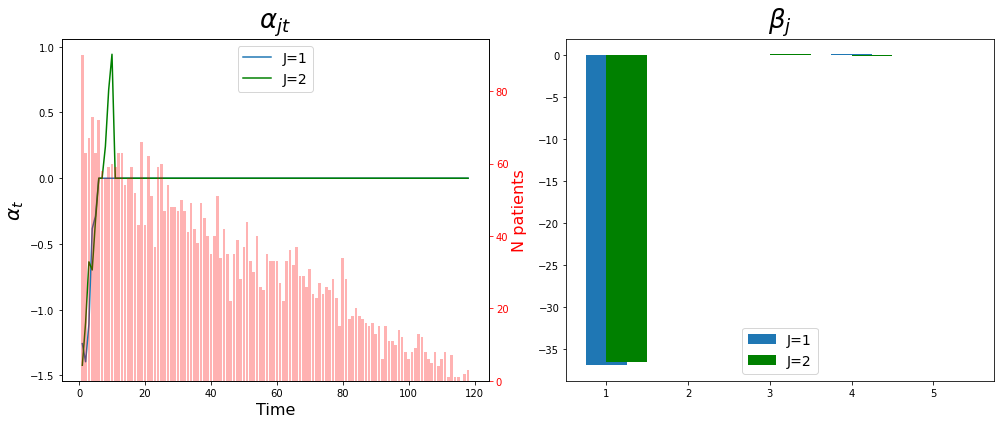

In [21]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
ax = axes[0]
ax.set_title(r'$\alpha_{jt}$', fontsize=26)
tmp_ajt = alpha_df[alpha_df['J'] == 1]
ax.plot(tmp_ajt['X'].values, tmp_ajt['alpha_jt'].values, label='J=1')
tmp_ajt = alpha_df[alpha_df['J'] == 2]
ax.plot(tmp_ajt['X'].values, tmp_ajt['alpha_jt'].values, color='g', label='J=2')
ax.set_xlabel(r'Time', fontsize=16)
ax.set_ylabel(r'$\alpha_{t}$', fontsize=20)
ax.legend(loc='upper center', fontsize=14)
ax2 = ax.twinx()
ax2.bar(alpha_df.groupby('X')['n_jt'].sum().index, alpha_df.groupby('X')['n_jt'].sum().values, color='r', alpha=0.3)
ax2.set_ylabel('N patients', fontsize=16, color='red')
ax2.tick_params(axis='y', colors='red')

ax = axes[1]
ax.set_title(r'$\beta_{j}$', fontsize=26)
ax.bar(np.arange(1, n_cov+1), beta_models[1].params_.values, label='J=1', width=0.5)
ax.bar(np.arange(1, n_cov+1), beta_models[2].params_.values, color='g', label='J=2', align='edge', width=0.5)
ax.legend(loc='lower center', fontsize=14)

fig.tight_layout()

## Comparison (WIP)

In [17]:
pd.DataFrame(index=['N=1000', 'N=10000', 'N=100000'], columns=['Train MSE (oracle)', 'Test MSE (oracle)', 'computation time'])

,Train MSE (oracle),Test MSE (oracle),computation time
N=1000,NaN,NaN,NaN
N=10000,NaN,NaN,NaN
N=100000,NaN,NaN,NaN
